# Setup

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories

from src.python.metrics import performance_metrics, bootstrapped_metrics
from src.python.helpers import log_with_inf_noise_addition, computation_times
from src.python.visualization import plot_approximations, plot_computation_times

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

c:\Python\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Python\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Python\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Python\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' 

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Load data

In [3]:
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison', 'nested_models')
bridge_file = '2022_12_19_BF_BS'
NN_fixed_file = '2022_12_14_BF_NN_fixed'
NN_variable_file = '2022_12_14_BF_NN_variable'

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))
NN_variable = pd.read_csv(os.path.join(comparison_folder, NN_variable_file))


results_list = [bridge, NN_fixed, NN_variable]

# Calculate performance metrics

In [4]:
n_bootstrap = 100000
names = ['Bridge sampling', 'Fixed network', 'Variable network']
metrics = ['Accuracy', 'ROC AUC', 'MAE', 'RMSE', 'Log score', 'SBC']

# Calculate performance metrics
perf_metrics = performance_metrics(results_list, names=names, metrics=metrics, model_prior=0.5)

# Calculate bootstrapped performance metrics
metrics_means, metrics_ses = bootstrapped_metrics(results_list, 1000, names=names, metrics=metrics, model_prior=0.5)

In [5]:
# Raw results
perf_metrics

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.86,0.9176,0.187275,0.320515,0.317158,-0.017106
Fixed network,0.85,0.9136,0.196363,0.331757,0.332717,-0.024720
Variable network,0.86,0.9168,0.187365,0.320264,0.316651,-0.016005


In [6]:
# Bootstrapped means
metrics_means

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.86060,0.916732,0.187387,0.318675,0.317611,-0.015103
Fixed network,0.85056,0.912794,0.196536,0.330039,0.333145,-0.022775
Variable network,0.86060,0.916034,0.187454,0.318374,0.317011,-0.013988


In [7]:
# Bootstrapped standard errors
metrics_ses

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.034952,0.031126,0.026399,0.034405,0.059112,0.042029
Fixed network,0.035840,0.031239,0.026997,0.033854,0.058862,0.041727
Variable network,0.034952,0.030955,0.026296,0.034360,0.058701,0.042040


In [8]:
# Convert to latex table
metrics_means = metrics_means.round(2).drop('ROC AUC', axis=1) # drop ROC AUC column as results do not add much information
metrics_ses = metrics_ses.round(2).drop('ROC AUC', axis=1) # drop ROC AUC column as results do not add much information

for row in range(metrics_means.shape[0]):
    for col in range(metrics_means.shape[1]):
        metrics_means.iloc[row,col] = f'{metrics_means.iloc[row,col]}' + f' ({metrics_ses.iloc[row,col]})'

print(metrics_means.style.to_latex(position='h', position_float='centering', hrules=True))

\begin{table}[h]
\centering
\begin{tabular}{llllll}
\toprule
 & Accuracy & MAE & RMSE & Log score & SBC \\
\midrule
Bridge sampling & 0.86 (0.03) & 0.19 (0.03) & 0.32 (0.03) & 0.32 (0.06) & -0.02 (0.04) \\
Fixed network & 0.85 (0.04) & 0.2 (0.03) & 0.33 (0.03) & 0.33 (0.06) & -0.02 (0.04) \\
Variable network & 0.86 (0.03) & 0.19 (0.03) & 0.32 (0.03) & 0.32 (0.06) & -0.01 (0.04) \\
\bottomrule
\end{tabular}
\end{table}



In [9]:
# How do the proportions of selected models look like?

print('True proportion = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling proportion = {}'.format(bridge['selected_model'].mean()))
print('NN fixed proportion = {}'.format(NN_fixed['selected_model'].mean()))
print('NN variable proportion = {}'.format(NN_variable['selected_model'].mean()))

True proportion = 0.5
Bridge Sampling proportion = 0.46
NN fixed proportion = 0.45
NN variable proportion = 0.46


# Plot PMPs & log BFs

In [10]:
# Compute Log BFs

log_bridge_bfs = log_with_inf_noise_addition(bridge)
log_NN_fixed_bfs = log_with_inf_noise_addition(NN_fixed)
log_NN_variable_bfs = log_with_inf_noise_addition(NN_variable)

In [11]:
model_names = ['$\mathcal{M}_1$', '$\mathcal{M}_2$']

## BS vs fixed NN

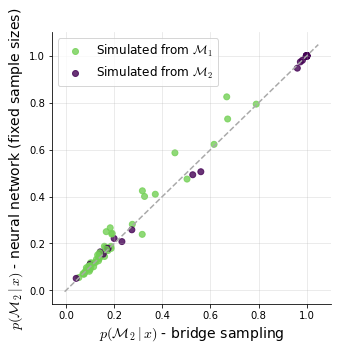

In [12]:
# PMPs
plot_approximations(bridge, NN_fixed, approximated_outcome='PMPs', 
                    NN_name='fixed network', model_names=model_names, save=False)

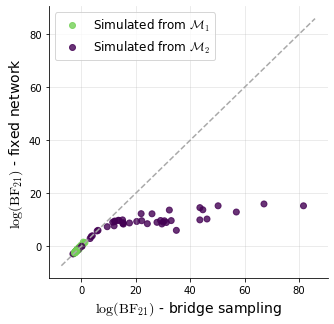

In [19]:
# Log BFs
plot_approximations(bridge, NN_fixed, approximated_outcome='Log BFs', 
                    NN_name='fixed network', model_names=model_names, save=False)

# of included datasets: 73


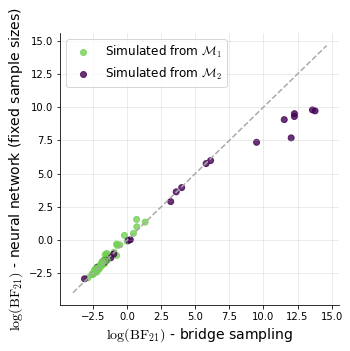

In [14]:
# Log Bfs with filter
filter = bridge['bayes_factor']<1000000
bridge_filtered = bridge[filter].reset_index(drop=True)
NN_fixed_filtered = NN_fixed[filter].reset_index(drop=True)
print('# of included datasets: {}'.format(sum(filter)))

plot_approximations(bridge_filtered, NN_fixed_filtered, approximated_outcome='Log BFs', 
                    NN_name='neural network (fixed sample sizes)', model_names=model_names, save=False)

## BS vs variable NN

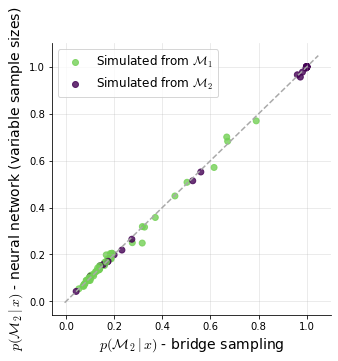

In [15]:
# PMPs
plot_approximations(bridge, NN_variable, approximated_outcome='PMPs', 
                    NN_name='variable network', model_names=model_names, save=False)

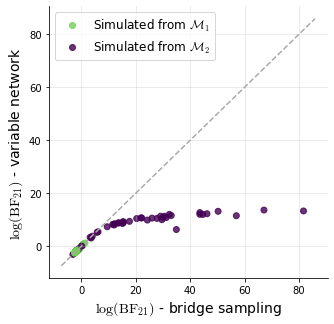

In [20]:
# Log BFs
plot_approximations(bridge, NN_variable, approximated_outcome='Log BFs', 
                    NN_name='variable network', model_names=model_names, save=False)

# of included datasets: 73


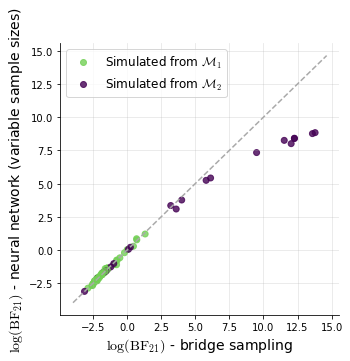

In [17]:
# Log Bfs with filter
filter = bridge['bayes_factor']<1000000
bridge_filtered = bridge[filter].reset_index(drop=True)
NN_variable_filtered = NN_variable[filter].reset_index(drop=True)
print('# of included datasets: {}'.format(sum(filter)))

plot_approximations(bridge_filtered, NN_variable_filtered, approximated_outcome='Log BFs', 
                    NN_name='neural network (variable sample sizes)', model_names=model_names, save=False)

# Plot together for publication

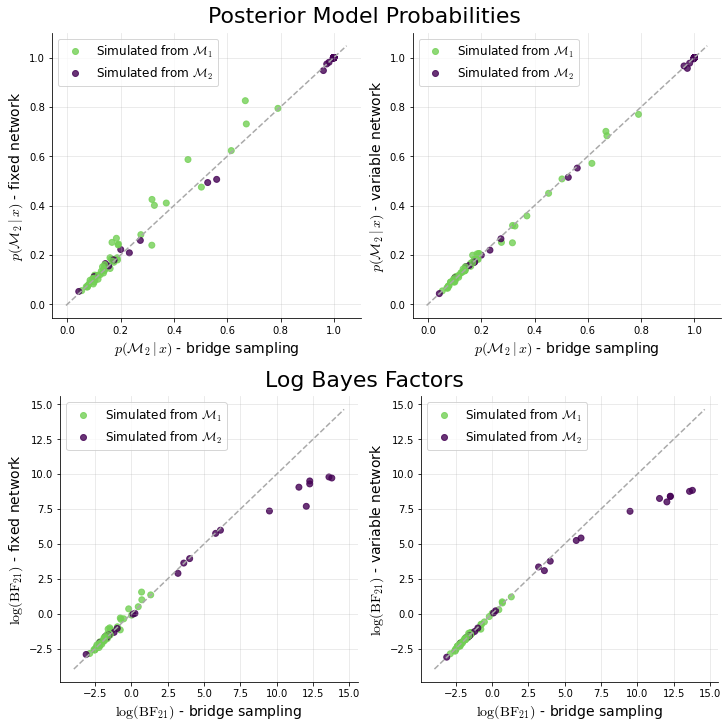

In [19]:
# Plot with PMP/log BF suptitles

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigure_titles = ['Posterior Model Probabilities', 'Log Bayes Factors']

bridge_list = [bridge, bridge_filtered]
NN_fixed_list = [NN_fixed, NN_fixed_filtered]
NN_variable_list = [NN_variable, NN_variable_filtered]

outcomes = ['PMPs', 'Log BFs']

# Use subfig to enable row titles
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=22)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)

    plot_approximations(bridge_list[row], NN_fixed_list[row], approximated_outcome=outcomes[row], 
                        NN_name='fixed network', model_names=model_names, ax=axs[0])
    plot_approximations(bridge_list[row], NN_variable_list[row], approximated_outcome=outcomes[row], 
                        NN_name='variable network', model_names=model_names, ax=axs[1])

plt.savefig('bs_comparison_convergence.pdf', dpi=300, bbox_inches='tight')

In [36]:
# map log BF where divergence starts (9.49) to BF and PMP
print(np.exp(9.49)) # BF
print(np.exp(9.49)/(np.exp(9.49)+1)) # PMP

13226.795326641039
0.9999244016122637


# Find biggest discrepancies and compare implications

In [5]:
# Find biggest PMP discrepancies
divergence_fixed = np.argmax(abs(bridge["m1_prob"] - NN_fixed["m1_prob"]))
divergence_variable = np.argmax(abs(bridge["m1_prob"] - NN_variable["m1_prob"]))

In [14]:
np.sort(abs(bridge["m1_prob"] - NN_fixed["m1_prob"]))

array([0.00000012, 0.00000024, 0.00000024, 0.00000048, 0.00000107,
       0.00000119, 0.0000025 , 0.00000465, 0.00000489, 0.00003493,
       0.00004152, 0.00004825, 0.00004864, 0.00005454, 0.00005905,
       0.00006139, 0.00006268, 0.00006366, 0.00006616, 0.00006855,
       0.00006946, 0.00008698, 0.00008869, 0.0001061 , 0.00011289,
       0.00012255, 0.00012342, 0.00013053, 0.00013986, 0.00015602,
       0.00019008, 0.00020546, 0.0002287 , 0.00023911, 0.00033935,
       0.00045146, 0.00056322, 0.00061387, 0.00064295, 0.00097968,
       0.00105735, 0.00111455, 0.00119475, 0.00125259, 0.00135161,
       0.00206344, 0.00251472, 0.00256238, 0.00312955, 0.00370816,
       0.0037204 , 0.00386193, 0.00445578, 0.0045009 , 0.00464432,
       0.00555903, 0.00561152, 0.00613002, 0.00626411, 0.00626579,
       0.00633357, 0.00732106, 0.00761301, 0.00879679, 0.00889649,
       0.00891666, 0.00894527, 0.00910383, 0.00935501, 0.01097207,
       0.01131284, 0.01176272, 0.01287693, 0.01347035, 0.01404

In [15]:
# Look up respective PMPs: Bridge vs. fixed network
print(f'PMP Bridge sampling: {bridge.loc[divergence_fixed, "m1_prob"]}')
print(f'PMP NN fixed: {NN_fixed.loc[divergence_fixed, "m1_prob"]}')

PMP Bridge sampling: 0.667725326426574
PMP NN fixed: 0.8251764178276062


In [11]:
# Look up respective BFs: Bridge vs. fixed network
print(f'BF Bridge sampling: {bridge.loc[divergence_fixed, "bayes_factor"]}')
print(f'BF NN fixed: {NN_fixed.loc[divergence_fixed, "bayes_factor"]}')

BF Bridge sampling: 2.00955829478832
BF NN fixed: 4.720052109525467


In [16]:
# Look up respective PMPs: Bridge vs. variable network
print(f'PMP Bridge sampling: {bridge.loc[divergence_variable, "m1_prob"]}')
print(f'PMP NN variable: {NN_variable.loc[divergence_variable, "m1_prob"]}')

PMP Bridge sampling: 0.316779572028838
PMP NN variable: 0.2487272769212722


In [13]:
# Look up respective BFs: Bridge vs. variable network
print(f'BF Bridge sampling: {bridge.loc[divergence_variable, "bayes_factor"]}')
print(f'BF NN variable: {NN_variable.loc[divergence_variable, "bayes_factor"]}')

BF Bridge sampling: 0.463656470239118
BF NN variable: 0.331074547605008


# Plot computation times as function of data sets

In [5]:
# Calculate computation times
results_time_list = computation_times(results_list)

In [17]:
# Mean computation times per phase
# Bridge Sampling
print('Stan: {}seconds / {}minutes'.format(round(np.mean(bridge['stan_time']), 2), round((np.mean(bridge['stan_time'])/60), 2)))
print('Bridge: {}seconds / {}minutes'.format(round(np.mean(bridge['bridge_time']), 2), round((np.mean(bridge['bridge_time'])/60), 2)))

# NN fixed
print('NN fixed training: {}seconds / {}minutes'.format(round(np.mean(NN_fixed['training_time']), 2), round(np.mean(NN_fixed['training_time'])/60), 2))
print('NN fixed inference: {}seconds'.format(np.mean(NN_fixed['inference_time'])))

# NN variable
print('NN variable training: {}seconds / {}minutes'.format(round(np.mean(NN_variable['training_time']), 2), round(np.mean(NN_variable['training_time'])/60), 2))
print('NN variable inference: {}seconds'.format(np.mean(NN_variable['inference_time'])))

Stan: 52.19seconds / 0.87minutes
Bridge: 38.46seconds / 0.64minutes
NN fixed training: 745.1seconds / 12minutes
NN fixed inference: 0.0025138789999982seconds
NN variable training: 2912.23seconds / 49minutes
NN variable inference: 0.0031704060000082995seconds


In [25]:
(np.mean(NN_fixed['training_time'])+np.sum(NN_fixed['inference_time']))

745.3522935999999

In [30]:
9065.88/60

151.09799999999998

In [27]:
# Total times

# Bridge Sampling
print('Stan+Bridge: {}seconds / {}minutes'.format(round(np.sum(bridge['bridge_time'])+np.sum(bridge['stan_time']), 2), round((np.sum(bridge['bridge_time'])+np.sum(bridge['stan_time']))/60), 2))

# NN fixed
print('NN fixed training+inference: {}seconds / {}minutes'.format(round((np.mean(NN_fixed['training_time'])+np.sum(NN_fixed['inference_time'])), 2), round((np.mean(NN_fixed['training_time'])+np.sum(NN_fixed['inference_time']))/60), 2))

# NN variable
print('NN fixed training+inference: {}seconds / {}minutes'.format(round((np.mean(NN_variable['training_time'])+np.sum(NN_variable['inference_time'])), 2), round((np.mean(NN_variable['training_time'])+np.sum(NN_variable['inference_time']))/60), 2))

Stan+Bridge: 9065.88seconds / 151minutes
NN fixed training+inference: 745.35seconds / 12minutes
NN fixed training+inference: 2912.55seconds / 49minutes


In [33]:
9142/60

152.36666666666667

In [31]:
# Stan compilation time in seconds
results_list[0]['compile_time']

0     42.408955
1     42.408955
2     42.408955
3     42.408955
4     42.408955
        ...    
95    42.408955
96    42.408955
97    42.408955
98    42.408955
99    42.408955
Name: compile_time, Length: 100, dtype: float64

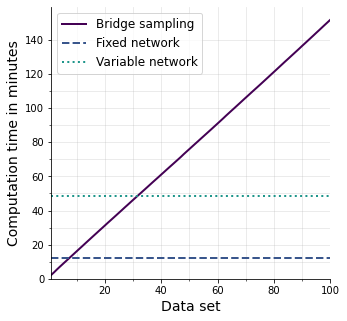

In [24]:
plot_computation_times(results_time_list, names=names, save=True)

In [29]:
results_time_list

[1        2.324134
 2        3.841673
 3        5.479971
 4        7.028234
 5        8.549732
           ...    
 96     145.655486
 97     147.208420
 98     148.752472
 99     150.272595
 100    151.804835
 Length: 100, dtype: float64,
 1      12.418390
 2      12.418432
 3      12.418474
 4      12.418516
 5      12.418558
          ...    
 96     12.422371
 97     12.422413
 98     12.422454
 99     12.422496
 100    12.422538
 Length: 100, dtype: float64,
 1      48.537282
 2      48.537335
 3      48.537387
 4      48.537440
 5      48.537493
          ...    
 96     48.542302
 97     48.542354
 98     48.542407
 99     48.542460
 100    48.542513
 Length: 100, dtype: float64]

In [28]:
# Get minimum number of datasets for which NNs are faster than bridge sampling

print(np.where(results_time_list[0] > results_time_list[1])[0][0]+1) # +1 as numpy uses 0-based indexing
print(np.where(results_time_list[0] > results_time_list[2])[0][0]+1) # +1 as numpy uses 0-based indexing

8
32
